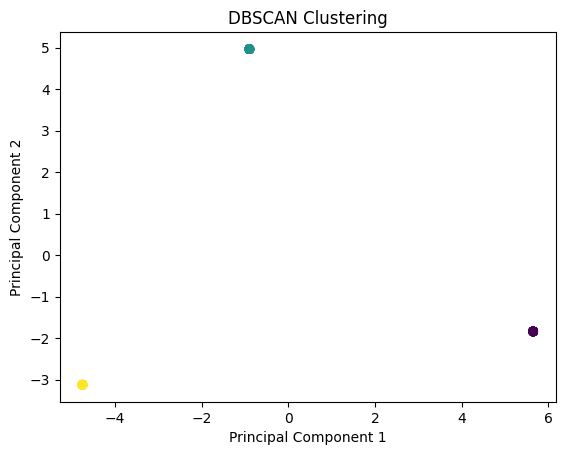

                nam_branch                    nam_cust_full  \
0         GURGAON, HARYANA          MANOJ  JAGDISH MALHOTRA   
1         GURGAON, HARYANA              DHIRENDRA  TRIPATHI   
2   INDORE, MADHYA PRADESH                        USHA JAIN   
3         GURGAON, HARYANA          MANOJ  JAGDISH MALHOTRA   
4         GURGAON, HARYANA              DHIRENDRA  TRIPATHI   
..                     ...                              ...   
94        GURGAON, HARYANA              MUSSARAT KAUR  KANG   
95  INDORE, MADHYA PRADESH     SUPERSTAR MULTITRADE PVT LTD   
96        GURGAON, HARYANA        RAGHVENDRA PRASAD  TIWARI   
97        GURGAON, HARYANA  HOLIDAYS AND RESORTS ASSOCIATES   
98  INDORE, MADHYA PRADESH           KAILASHCHAND  BHARTIYA   

   txt_profession_desc nam_custadr_city nam_custadr_state  \
0       Business Owner        NEW DELHI             DELHI   
1             SALARIED           Mumbai       MAHARASHTRA   
2            HOUSEWIFE           INDORE    MADHYA PRADESH   

In [ ]:
# Segmentation Mdoel Clustering Based

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Load the Excel file
xls = pd.ExcelFile('/content/Cust_segmentation_and_Recomendation.xlsx')

# Load the data from the first sheet
df = xls.parse('Sheet1')

# Select the numerical columns for clustering
df_clustering = df[['Bill Payment', 'Dining ', 'Loan', 'No_of_transactions', 'Total Spent ']].copy()

# Convert columns with numeric strings to floats
for col in df_clustering.columns:
    df_clustering[col] = df_clustering[col].apply(lambda x: float(str(x).replace(",", "")) if pd.notnull(x) else 0)

# Select the categorical columns for one-hot encoding
df_categorical = df[['nam_branch', 'nam_cust_full', 'txt_profession_desc', 'nam_custadr_city',
                     'nam_custadr_state', 'txt_holdadr_add3', 'txt_cust_typ', 'risk_category',
                     'wealth_mng_cust', 'annual_inc_trnor', 'resi_type', 'nam_product',
                     'promotional_offers']].copy()

# Perform one-hot encoding
df_encoded = pd.get_dummies(df_categorical)

# Combine the encoded categorical data with the numerical data
df_combined = pd.concat([df_clustering, df_encoded], axis=1)

# Fill any NaNs with zero
df_combined.fillna(0, inplace=True)

# Normalize the combined data
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_combined)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized)

# Apply DBSCAN algorithm
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df_pca)

# Plot the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Add the cluster labels to the original dataframe
df['Cluster'] = clusters

# Print the data with the cluster they belong to
print(df)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Ensure all column names are strings
df_categorical.columns = df_categorical.columns.astype(str)

# Initialize one-hot encoder with handle_unknown='ignore'
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the data using one-hot encoder
df_encoded = ohe.fit_transform(df_categorical)

# Manually generate feature names
feature_names = []
for i, col in enumerate(df_categorical.columns):
    for category in ohe.categories_[i]:
        feature_names.append(f"{col}_{category}")

# Redefine df_combined, df_normalized, df_pca, and clusters
df_combined = pd.concat([df_clustering, pd.DataFrame(df_encoded, columns=feature_names)], axis=1)
df_combined.fillna(0, inplace=True)
df_normalized = scaler.fit_transform(df_combined)
df_pca = pca.fit_transform(df_normalized)
clusters = dbscan.fit_predict(df_pca)

# Add the cluster labels to the original dataframe
df['Cluster'] = clusters

def predict_cluster(new_data, dbscan, scaler, pca, ohe):
    # Preprocess new_data
    new_data_clustering = pd.DataFrame(new_data['numerical'], index=[0])
    new_data_categorical = pd.DataFrame(new_data['categorical'], index=[0])
    for col in new_data_clustering.columns:
        new_data_clustering[col] = new_data_clustering[col].apply(lambda x: float(str(x).replace(",", "")) if pd.notnull(x) else 0)
    new_data_categorical = new_data_categorical.applymap(str)
    new_data_encoded = ohe.transform(new_data_categorical)
    # Manually generate feature names for new data
    new_feature_names = []
    for i, col in enumerate(new_data_categorical.columns):
        for category in ohe.categories_[i]:
            new_feature_names.append(f"{col}_{category}")
    new_data_combined = pd.concat([new_data_clustering, pd.DataFrame(new_data_encoded, columns=new_feature_names)], axis=1)
    new_data_combined.fillna(0, inplace=True)
    new_data_normalized = scaler.transform(new_data_combined)
    new_data_pca = pca.transform(new_data_normalized)

    # Fit DBSCAN model with new_data included
    new_clusters = dbscan.fit_predict(np.concatenate([df_pca, new_data_pca]))

    return new_clusters[-1]  # Return the cluster for new_data

# Test with a sample row from the data
sample_row = df.sample(2)

# Prepare the new_data dictionary
new_data = {
    'numerical': sample_row[['Bill Payment', 'Dining ', 'Loan', 'No_of_transactions', 'Total Spent ']].iloc[0].to_dict(),
    'categorical': sample_row[['nam_branch', 'nam_cust_full', 'txt_profession_desc', 'nam_custadr_city',
                                'nam_custadr_state', 'txt_holdadr_add3', 'txt_cust_typ', 'risk_category',
                                'wealth_mng_cust', 'annual_inc_trnor', 'resi_type', 'nam_product',
                                'promotional_offers']].iloc[0].to_dict()
}

# Use the function to predict the cluster for the new data point
predict_cluster(new_data, dbscan, scaler, pca, ohe)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2

In [ ]:
# Recomendation model
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load the Excel file
df = pd.read_excel("/content/Cust_segmentation_and_Recomendation.xlsx")

# Identify the categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Convert all categorical columns to string type
df[categorical_columns] = df[categorical_columns].astype(str)

# Initialize a OneHotEncoder for categorical variables and a MinMaxScaler for numerical variables
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = MinMaxScaler()

# Apply one-hot encoding to categorical columns
categorical_features = ohe.fit_transform(df[categorical_columns].fillna('Missing'))

# Apply scaling to numerical columns
numerical_features = scaler.fit_transform(df[numerical_columns].fillna(0))

# Combine the processed categorical and numerical features
customer_profiles = np.hstack([categorical_features, numerical_features])

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(customer_profiles)

# Specify the index of the customer we're generating recommendations for
customer_index = 0

# Get the similarity scores for this customer
similarity_scores = similarity_matrix[customer_index]

# Get the indices of the customers sorted by similarity
similar_customer_indices = np.argsort(similarity_scores)[::-1]

# Get the top 5 most similar customers (excluding the customer themselves)
top_5_similar_customers = similar_customer_indices[1:6]

# Display the 'Customer_Value', 'Profession', 'Frequency_of_Transactions', and 'Type_of_Transactions' for these customers
existing_columns = ['Customer_Value', 'Profession', 'Frequency_of_Transactions', 'Type_of_Transactions']
recommendations = df.loc[top_5_similar_customers, existing_columns]
print(recommendations)


          Customer_Value             Profession Frequency_of_Transactions  \
3   High-Value Customers  SMALL BUSINESS OWNERS       FREQUENT PURCHASERS   
72  High-Value Customers  SMALL BUSINESS OWNERS       FREQUENT PURCHASERS   
78  High-Value Customers  SMALL BUSINESS OWNERS       FREQUENT PURCHASERS   
57  High-Value Customers  SMALL BUSINESS OWNERS       FREQUENT PURCHASERS   
21  High-Value Customers  SMALL BUSINESS OWNERS       FREQUENT PURCHASERS   

       Type_of_Transactions  
3   HIGH VALUE TRANSACTIONS  
72  HIGH VALUE TRANSACTIONS  
78  HIGH VALUE TRANSACTIONS  
57  HIGH VALUE TRANSACTIONS  
21  HIGH VALUE TRANSACTIONS  


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
